In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
import numpy as np
import pandas as pd

from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [82]:
image_dir = Path('/content/drive/MyDrive/CP363107 Data Science for Marketing/lab10/imageprocessing')
image_dir

PosixPath('/content/drive/MyDrive/CP363107 Data Science for Marketing/lab10/imageprocessing')

In [83]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

In [84]:
image_df

,Filepath,Label
0,/content/drive/MyDrive/CP363107 Data Science f...,healthy
1,/content/drive/MyDrive/CP363107 Data Science f...,healthy
2,/content/drive/MyDrive/CP363107 Data Science f...,healthy
3,/content/drive/MyDrive/CP363107 Data Science f...,healthy
4,/content/drive/MyDrive/CP363107 Data Science f...,healthy
5,/content/drive/MyDrive/CP363107 Data Science f...,healthy
6,/content/drive/MyDrive/CP363107 Data Science f...,healthy
7,/content/drive/MyDrive/CP363107 Data Science f...,healthy
8,/content/drive/MyDrive/CP363107 Data Science f...,healthy
9,/content/drive/MyDrive/CP363107 Data Science f...,healthy


In [85]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True)

In [86]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

In [87]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False

)

Found 19 validated image filenames belonging to 2 classes.
Found 4 validated image filenames belonging to 2 classes.
Found 11 validated image filenames belonging to 2 classes.


In [88]:
from PIL import Image
import io

inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )
    ]
)

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/100
1/1 [==============================] - 1s 1s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 7/100
1/1 [==============================] - 1s 973ms/step - loss: 0.6932 - accuracy: 0.

In [89]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 global_average_pooling2d_4  (None, 32)                0   

In [90]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.69315
Test Accuracy: 50.00%


In [91]:
predictions = (model.predict(test_images)>0.5).astype(np.int32)

1/1 [==============================] - 1s 739ms/step


In [92]:
predictions

array([[0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0]], dtype=int32)

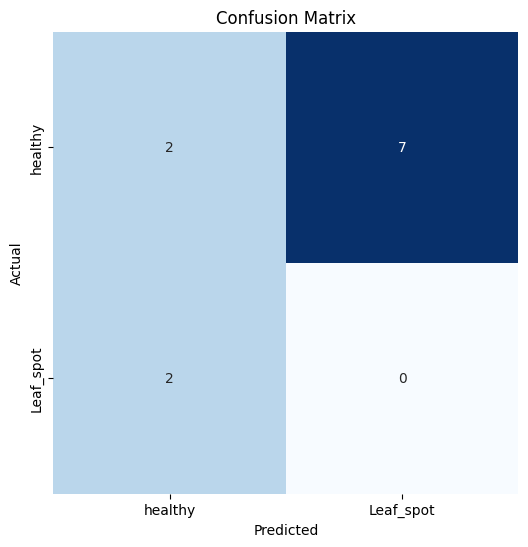

Classification Report:
----------------------
               precision    recall  f1-score   support

     healthy       0.50      0.22      0.31         9
   Leaf_spot       0.00      0.00      0.00         2

    accuracy                           0.18        11
   macro avg       0.25      0.11      0.15        11
weighted avg       0.41      0.18      0.25        11



In [93]:
cm = confusion_matrix(test_images.labels, predictions, labels=[0, 1])
clr = classification_report(test_images.labels, predictions, labels=[0, 1], target_names=["healthy","Leaf_spot"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["healthy","Leaf_spot"])
plt.yticks(ticks=[0.5, 1.5], labels=["healthy","Leaf_spot"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)


In [104]:
image_dir = Path('/content/drive/MyDrive/CP363107 Data Science for Marketing/lab10/unseen')

In [105]:
filepaths = list(image_dir.glob(r'**/*.JPG'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df_unseen = pd.concat([filepaths, labels], axis=1)
print(image_df_unseen)

                                            Filepath   Label
0  /content/drive/MyDrive/CP363107 Data Science f...  unseen


In [106]:
test_generator_unseen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)
test_images_unseen = test_generator_unseen.flow_from_dataframe(
    dataframe=image_df_unseen,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32
)

Found 1 validated image filenames belonging to 1 classes.


In [107]:
predictions_unseen = (model.predict(test_images_unseen)>0.5).astype(np.int32)
print(predictions_unseen)
if predictions_unseen == 0:
  print ("Healthy")
else:
  print ("Leafspot")

1/1 [==============================] - 0s 48ms/step
[[1]]
Leafspot


In [108]:
# save model
model.save('/content/drive/MyDrive/CP363107 Data Science for Marketing/lab10/imageprocessing/plant_diease.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
